# 1d2v-GEMPIC-Vlasov-Maxwell-Solver

## Import modules

In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import fembase as fem
import picbase as pic
from bsplines import Bspline
from scipy.integrate import fixed_quad
from scipy import integrate

## Simulation parameters

In [77]:
# wavenumber of perturbations
k = 1.25

# boundaries and lenght of domain
a_boundary = 0
b_boundary = 2*np.pi/k
Lx = b_boundary - a_boundary

# number of elements and element boundaries
Nel = 16
el_b = np.linspace(a_boundary, b_boundary, Nel + 1)

# element size
dx = (b_boundary - a_boundary)/Nel

# degree of basis functions in V0
degree = 3

# degree and width of B-spline smoothing kernel
p = 3
Swidth = 0.6
dx_S = Swidth/(p + 1)


# number of particles for simulation
Np = np.int(5e4)

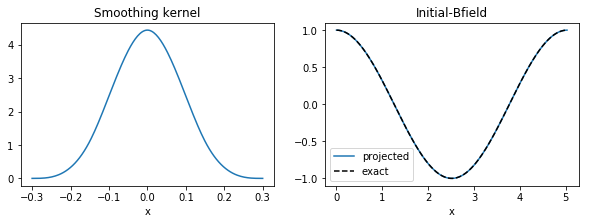

In [78]:
# create and plot smoothing kernel
a_kernel = -(p + 1)/2*dx_S
b_kernel = +(p + 1)/2*dx_S
nodes = np.linspace(a_kernel,b_kernel,p + 2)
le = np.linspace(a_kernel - p*dx_S,a_kernel - dx_S,p)
ri = np.linspace(b_kernel + dx_S,b_kernel + p*dx_S,p)

T = np.array(list(le)  + list(nodes) + list(ri))
bsp_S = Bspline(T,p)


def kernel(x,length = 2):
       
    if length == 2:
        values = np.zeros(len(x))
        
        for i in range(len(x)):
            if np.abs(x[i]) >= Swidth/2:
                values[i] = 0.
        
            else:
                values[i] =  1/dx_S*bsp_S(x[i],p)
        return values
            
    if length == 1:
        if np.abs(x) >= Swidth/2:
            return 0.
        
        else:
            return 1/dx_S*bsp_S(x,p)
        
        
nx = 200
supp = np.linspace(a_kernel,b_kernel,nx)
y = kernel(supp)

f1 = plt.figure()
f1.set_figheight(3)
f1.set_figwidth(10)

plt.subplot(121)
plt.plot(supp,y)
plt.xlabel('x')
plt.title('Smoothing kernel')


# create Lagrange shape functions in V1 and V0 and compute global matrices M0 and M1
shapefun = fem.LagrangeShape(np.linspace(-1, 1, degree + 1))
Nbase_0, mass_0 = fem.lag_assemb(el_b, shapefun.mass0, shapefun.stiff0, bcs = 2)[1:3]
Nbase_1, mass_1 = fem.lag_assemb(el_b, shapefun.mass1, shapefun.stiff1, basis = 2, bcs = 2)[1:3]


# initialize B-field, compute initial coefficients by L2-projection on the basis and check result
beta = 1.

B_0 = lambda x: beta*np.cos(k*x)
bbar = fem.lag_L2prod(B_0, shapefun.chi, el_b, basis = 2)[2]

b = np.linalg.solve(mass_1,bbar)


fun = fem.lag_fun(b, shapefun.chi, el_b, basis = 2)[2]
x2 = np.linspace(a_boundary, b_boundary, 200)

plt.subplot(122)
plt.plot(x2, fun(x2), label = 'projected')
plt.plot(x2, B_0(x2), 'k--', label = 'exact')
plt.xlabel('x')
plt.title('Initial-Bfield')
plt.legend()

# assemble gradient matrix
grad1 = np.ones(Nbase_0)
grad2 = -np.ones(Nbase_0 - 1)
Grad = np.diag(grad1) + np.diag(grad2, -1)
Grad = np.append(Grad, [np.zeros(Nbase_0)], axis = 0)
Grad[-1, -1] = -1

# initialize distribution function and define sampling distribution for initial markers
sigma_1 = 0.02/np.sqrt(2)
sigma_2 = np.sqrt(12)*sigma_1
alpha = 0

f0 = lambda x,vx,vy: 1/(2*np.pi*sigma_1*sigma_2)*np.exp(-1/2*(vx**2/sigma_1**2 + vy**2/sigma_2**2))*(1 + alpha*np.cos(k*x))
g0 = lambda x,vx,vy: 1/(2*np.pi*sigma_1*sigma_2)*np.exp(-1/2*(vx**2/sigma_1**2 + vy**2/sigma_2**2))*1/Lx



# create particles and compute weights
particles = np.zeros((Np,4))

particles[:, 0] = np.random.rand(Np)*Lx
particles[:, 1] = np.random.randn(Np)*sigma_1
particles[:, 2] = np.random.randn(Np)*sigma_2

particles[:, 3] = 1/Np*f0(particles[:, 0],particles[:, 1], particles[:, 2])/g0(particles[:, 0],particles[:, 1], particles[:, 2])

In [79]:
Nknots = Nel*degree + 1
glob_s = np.zeros(Nknots)
s = shapefun.s
rho = np.zeros(Nel*degree)
q = -1

for ie in range(Nel):
    for il in range(degree + 1):
            
        i = ie*degree + il
        glob_s[i] = el_b[ie] + (s[il] + 1)/2*(el_b[ie + 1] - el_b[ie])
        # assemble global knot vector

for i in range(Nel*degree):
    print(i)
    for j in range(Np):   
        fun2 = lambda x: kernel(particles[j,0] - x,1)
        rho[i] += 2*q/dx*particles[j,3]*integrate.quad(fun2,glob_s[i],glob_s[i+1])[0]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


In [80]:
fun = fem.lag_fun(rho, shapefun.chi, el_b, basis = 2)[2]

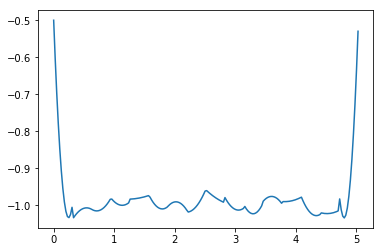

In [81]:
plt.plot(x2,fun(x2))

In [82]:
rho

array([-0.46295822, -0.63660682, -0.68197348, -0.68329985, -0.67327872,
       -0.67165984, -0.67566871, -0.67371634, -0.66260411, -0.65884882,
       -0.66560144, -0.66396956, -0.6548272 , -0.65321839, -0.65049517,
       -0.65730809, -0.67011513, -0.67166698, -0.66364528, -0.66072872,
       -0.66810092, -0.67710766, -0.66787856, -0.64964247, -0.64363027,
       -0.65237696, -0.65912693, -0.66111375, -0.67248719, -0.67392597,
       -0.67389331, -0.68093354, -0.67234518, -0.65446628, -0.65085125,
       -0.65712153, -0.65963465, -0.65830574, -0.65465061, -0.6621516 ,
       -0.67929954, -0.68438212, -0.68056307, -0.6808956 , -0.67808967,
       -0.6767328 , -0.64962426, -0.48299721])

In [60]:
all(x2 > 0.5)

False

In [63]:
test = 2.

In [64]:
test.size

AttributeError: 'float' object has no attribute 'size'